# [LG 에너지 솔루션]
## DX Expert 양성과정 WEEK 2
## Transformer - (1) 자연어처리 실습



## 강의 복습

강의자료 : Transformer, AGENDA 01 - Transformer & BERT

## 실습 요약

1. 본 실습에서는 사전 학습된 BERT를 활용하여 감성분석 모델을 구축합니다
2. 학습된 모델을 활용하여 평가를 진행합니다.


------

### STEP 0. 환경 구축하기
* 필요한 library들을 import 합니다

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import sys
import json
import random
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
#%matplotlib inline #생성한 figure를 notebook에서 볼 수있게 해주는 코드

import gensim
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.7.0 (default, Oct  9 2018, 10:31:47) 
[GCC 7.3.0]].
PyTorch version:[1.6.0].
device:[cuda:0].


In [ ]:
! pip install transformers==4.5.0 -q

In [ ]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

### STEP 1. 데이터 준비하기
금일 실습에서는 **Naver_shopping**에서 수집된 **리뷰 데이터**를 활용합니다.
* 제품별 후기를 별점과 함께 수집한 데이터
* 데이터셋 출처

  * 1) https://github.com/songys/AwesomeKorean_Data
  * 2) https://github.com/bab2min/corpus/tree/master/sentiment


* 해당 실습에서는 전체 데이터 중 50%인 10만개의 데이터를 사용함 (긍정 : 50000개, 부정 : 50000개)





In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/yukyunglee/LG_ES_Transformer

In [ ]:
# 데이터셋 읽기
with open('./LG_ES_Transformer/data/naver_shopping.txt','r',encoding='utf-8') as f:
  data = f.readlines()

In [ ]:
# 분석에 사용할 형태로 가공하기
rate = []
label = []
sentence = []
for cur_review in tqdm(data):
  # 평점과 리뷰 문장 분리
  cur_review = cur_review.split('\t')
  # 평점
  rate.append(cur_review[0])
  # 리뷰 문장
  sentence.append(cur_review[1].strip('\n'))
  # 평점 4,5 : Positive, 
  # 평점 1,2 : Negative
  if int(cur_review[0]) >3:
    label.append(0) # positive
  else:
    label.append(1) # negative

100%|██████████| 200000/200000 [00:00<00:00, 1077505.68it/s]


In [ ]:
# 데이터 프레임 형태로 변환하기
df = {
    "rate" : rate,
    "label" : label,
    "sentence" : sentence
}
df = pd.DataFrame(df)
df = df.sample(frac=0.5,replace=False, random_state=42)

<AxesSubplot:>

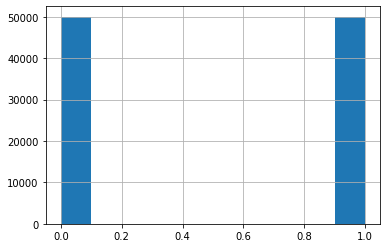

In [ ]:
df['label'].hist()

In [ ]:
df.head()

,rate,label,sentence
119737,2,1,마감이 안좋아요...실밥도 많고 바느질도 부족한 부분이 몇군데 있네요...교환받기 ...
72272,5,0,깨끗하게 잘 다듬어져 있어요. 맛도좋고요.
158154,4,0,재구매 배송빨라요 길냥이들이 잘먹어요~~ 대용량이라 좋네요~
65426,5,0,제품도 빨리 배송해주시고 꼼꼼하게 잘챙겨주셨어요
30074,5,0,기타 남 멋지고 예뻐요 여러 사은품도 좋아요


### STEP 2. 전처리 진행 (Preprocessing)

In [ ]:
review_sentences = df['sentence'].to_list()

In [ ]:
import re
def preprocess(text):
  text = re.sub('[-=+,#/\?:^$~@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', text)
  text = re.sub('[ㅠㅎㅋ]','', text)
  return text

In [ ]:
normalize_sentence = []
for sentence in tqdm(review_sentences):
  sentence = preprocess(sentence)
  normalize_sentence.append(sentence)

df['normalize_sentence'] = normalize_sentence

100%|██████████| 100000/100000 [00:00<00:00, 478746.08it/s]


### STEP 3. 토큰화 진행 (Tokenization)

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

tokenized_sentence = []
for sent in tqdm(normalize_sentence):
  sent = tokenizer.tokenize(sent)
  tokenized_sentence.append(sent) 

100%|██████████| 100000/100000 [00:06<00:00, 14733.52it/s]


In [ ]:
df['tokenized_sentence'] = tokenized_sentence

<AxesSubplot:>

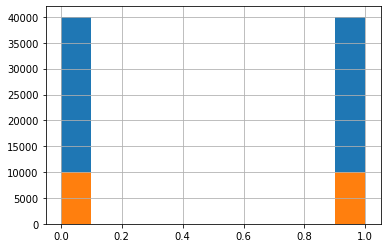

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size =0.2, random_state= 42)
train_df['label'].hist()
test_df['label'].hist()

### STEP 4. 벡터화 진행 (Vectorization)
* 해당 실습에서는 모델 내부에서 벡터화를 진행합니다
  

### STEP 5. 모델 구축하기 (Modeling)
* BERT를 활용하여 감성분석 모델 만들기


In [ ]:
from torch.utils.data import Dataset, DataLoader

class BERTDataset(Dataset):
  def __init__(self, df, tokenizer, max_seq_length=100):
    self.max_seq_length = max_seq_length
    self.tokenizer = tokenizer
    self.df = df
    self.inputs = df["normalize_sentence"].to_list() # input sentence는 input 혹은 source라는 단어로 표현됨
    self.targets = df["label"].to_list() # output label은 target으로 표현됨

    self.vocab = self.tokenizer.vocab
    self.pad_idx = self.vocab['[PAD]']
    self.cls_idx = self.vocab['[CLS]']
    self.sep_idx = self.vocab['[SEP]']
    self.mask_idx = self.vocab['[MASK]']

  def convert_inputs_to_feature(self, input):
    # STEP 1 : word to index
    # 문장을 token 단위로 분리한 후, 모델이 이해할 수 있는 형태인 숫자로 바꾸어줍니다

    tokenized_input = self.tokenizer.encode(input)


    # STEP 2 : pad or truncate token
    # max length에 따라 input 문장의 길이 조절하여 동일한 길이의 input으로 변환
    # batch단위로 학습을 하기위해 다음과 같은 과정을 거침
    diff = self.max_seq_length - len(tokenized_input)
    if diff > 0:
      tokenized_input += [self.pad_idx] * diff 
    else:
      tokenized_input = tokenized_input[:self.max_seq_length-1] + [self.sep_idx]
    
    return tokenized_input

  def idx2mask(self, token_ids):
    # output bool; attention mask 생성
    return [token_id != self.pad_idx for token_id in token_ids]

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    input = self.inputs[idx]
    target = self.targets[idx]

    tokenized_input = self.convert_inputs_to_feature(input)
    att_mask = self.idx2mask(tokenized_input)

    # print(len(tokenized_input))
    # print(self.max_seq_length)

    # tokenized input이 max_seq_length와 같은지 무조건 체크
    # att_mask가 max_seq_length와 같은지 무조건 체크
    assert len(tokenized_input) == self.max_seq_length
    assert len(att_mask) == self.max_seq_length

    batch = [
            torch.tensor(tokenized_input),
            torch.tensor(att_mask),
            torch.tensor(target),
    ]
    return batch

In [ ]:
# train
EPOCH = 5
BATCH_SIZE = 50
LR = 1e-5

In [ ]:
train_dataset = BERTDataset(
    df = train_df,
    tokenizer = tokenizer,
    max_seq_length=30)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True,
    )

In [ ]:
from transformers import BertForSequenceClassification , AdamW

model = BertForSequenceClassification.from_pretrained('klue/bert-base')
# 아래에 뜨는 warning은 무시해도 됨
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=LR)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [ ]:
model.train()
for epoch in range(EPOCH):
    batch_loss = []
    for step, batch in enumerate(train_loader):

        inputs, att_mask, targets = batch

        inputs = inputs.to(device)
        att_mask = att_mask.to(device)
        targets = targets.to(device)

        model.zero_grad()
        outputs = model(inputs, attention_mask=att_mask, labels=targets)
        
        loss = outputs[0]
        logit = outputs[1]
        batch_loss.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        if step % 100 == 0:
            print('[%d/%d] [%d/%d] %f' % (epoch+1, EPOCH, step, len(train_loader), loss.item()))

[1/5] [0/1600] 0.191980
[1/5] [100/1600] 0.230941
[1/5] [200/1600] 0.196641
[1/5] [300/1600] 0.134816
[1/5] [400/1600] 0.440798
[1/5] [500/1600] 0.194267
[1/5] [600/1600] 0.256130
[1/5] [700/1600] 0.451009
[1/5] [800/1600] 0.133638
[1/5] [900/1600] 0.127192
[1/5] [1000/1600] 0.147091
[1/5] [1100/1600] 0.252845
[1/5] [1200/1600] 0.143902
[1/5] [1300/1600] 0.370659
[1/5] [1400/1600] 0.198443
[1/5] [1500/1600] 0.222306
[2/5] [0/1600] 0.233456
[2/5] [100/1600] 0.124620
[2/5] [200/1600] 0.285418
[2/5] [300/1600] 0.108016
[2/5] [400/1600] 0.160531
[2/5] [500/1600] 0.334776
[2/5] [600/1600] 0.140136
[2/5] [700/1600] 0.258769
[2/5] [800/1600] 0.180803
[2/5] [900/1600] 0.205385
[2/5] [1000/1600] 0.173658
[2/5] [1100/1600] 0.137877
[2/5] [1200/1600] 0.174701
[2/5] [1300/1600] 0.158851
[2/5] [1400/1600] 0.116891
[2/5] [1500/1600] 0.102727
[3/5] [0/1600] 0.072394
[3/5] [100/1600] 0.244027
[3/5] [200/1600] 0.103308
[3/5] [300/1600] 0.050404
[3/5] [400/1600] 0.112321
[3/5] [500/1600] 0.057917
[3/5] 

In [ ]:
# test
test_dataset = BERTDataset(
    df = test_df,
    tokenizer = tokenizer,
    max_seq_length=30)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle=False,
    )

In [ ]:
model.eval()

model_prediction = []
test_label = []
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        inputs, att_mask, targets = batch

        inputs = inputs.to(device)
        att_mask = att_mask.to(device)
        targets = targets.to(device)

        outputs = model(inputs, attention_mask=att_mask, labels=targets)
        
        logit = outputs[1]

        preds = torch.argmax(F.softmax(logit),dim=1)
        preds = preds.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()

        model_prediction.extend(preds)
        test_label.extend(targets)
        assert len(model_prediction) == len(test_label)

/home/yukyung/anaconda3/envs/loganomaly/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# 성능 평가하기
print('Test data f1 score : ',f1_score(test_label, model_prediction, average='macro'))
print('Test data accuracy score : ',accuracy_score(test_label, model_prediction))

Test data f1 score :  0.9224997760243527
Test data accuracy score :  0.9225
